In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy


from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

from functools import partial

from IPython.display import GeoJSON

py.init_notebook_mode()

For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we'll never need to bin large data for visualization ever again.)

To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.

PLUTO data can be downloaded from [here](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page). Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the data dictionary, it'll come in handy for this assignment.

In [2]:
# Code to read in v17, column names have been updated (without upper case letters) for v18

# bk = pd.read_csv('PLUTO17v1.1/BK2017V11.csv')
# bx = pd.read_csv('PLUTO17v1.1/BX2017V11.csv')
# mn = pd.read_csv('PLUTO17v1.1/MN2017V11.csv')
# qn = pd.read_csv('PLUTO17v1.1/QN2017V11.csv')
# si = pd.read_csv('PLUTO17v1.1/SI2017V11.csv')

# ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True)

ny = pd.read_csv('nyc_pluto_18v2_1_csv/pluto_18v2_1.csv', low_memory=False)


# Getting rid of some outliers
ny = ny[(ny['yearbuilt'] > 1850) & (ny['yearbuilt'] < 2020) & (ny['numfloors'] != 0)]

I'll also do some prep for the geographic component of this data, which we'll be relying on for datashader.

You're not required to know how I'm retrieving the lattitude and longitude here, but for those interested: this dataset uses a flat x-y projection (assuming for a small enough area that the world is flat for easier calculations), and this needs to be projected back to traditional lattitude and longitude.

In [3]:


wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
ny['xcoord'] = 0.3048*ny['xcoord']
ny['ycoord'] = 0.3048*ny['ycoord']
ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['xcoord'].values, ny['ycoord'].values)

ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

## Part 1: Binning and Aggregation

Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and [2D histograms](https://plot.ly/python/2D-Histogram/) (also check out their close relatives: [2D density plots](https://plot.ly/python/2d-density-plots/) and the more general form: [heatmaps](https://plot.ly/python/heatmaps/).

While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [4]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('yearbuilt').count()['bbl'].index,
    y = ny.groupby('yearbuilt').count()['bbl']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.Figure(data = [trace], layout = layout)

py.iplot(fig)

Something looks off... You're going to have to deal with this imperfect data to answer this first question. 

But first: some notes on pandas. Pandas dataframes are a different beast than R dataframes, here are some tips to help you get up to speed:

---

Hello all, here are some pandas tips to help you guys through this homework:

[Indexing and Selecting](https://pandas.pydata.org/pandas-docs/stable/indexing.html): .loc and .iloc are the analogs for base R subsetting, or filter() in dplyr

[Group By](https://pandas.pydata.org/pandas-docs/stable/groupby.html):  This is the pandas analog to group_by() and the appended function the analog to summarize(). Try out a few examples of this, and display the results in Jupyter. Take note of what's happening to the indexes, you'll notice that they'll become hierarchical. I personally find this more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. Once you perform an aggregation, try running the resulting hierarchical datafrome through a [reset_index()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html).

[Reset_index](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html): I personally find the hierarchical indexes more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. reset_index() is a way of restoring a dataframe to a flatter index style. Grouping is where you'll notice it the most, but it's also useful when you filter data, and in a few other split-apply-combine workflows. With pandas indexes are more meaningful, so use this if you start getting unexpected results.

Indexes are more important in Pandas than in R. If you delve deeper into the using python for data science, you'll begin to see the benefits in many places (despite the personal gripes I highlighted above.) One place these indexes come in handy is with time series data. The pandas docs have a [huge section](http://pandas.pydata.org/pandas-docs/stable/timeseries.html) on datetime indexing. In particular, check out [resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html), which provides time series specific aggregation.

[Merging, joining, and concatenation](https://pandas.pydata.org/pandas-docs/stable/merging.html): There's some overlap between these different types of merges, so use this as your guide. Concat is a single function that replaces cbind and rbind in R, and the results are driven by the indexes. Read through these examples to get a feel on how these are performed, but you will have to manage your indexes when you're using these functions. Merges are fairly similar to merges in R, similarly mapping to SQL joins.

Apply: This is explained in the "group by" section linked above. These are your analogs to the plyr library in R. Take note of the lambda syntax used here, these are anonymous functions in python. Rather than predefining a custom function, you can just define it inline using lambda.

Browse through the other sections for some other specifics, in particular reshaping and categorical data (pandas' answer to factors.) Pandas can take a while to get used to, but it is a pretty strong framework that makes more advanced functions easier once you get used to it. Rolling functions for example follow logically from the apply workflow (and led to the best google results ever when I first tried to find this out and googled "pandas rolling")

Google Wes Mckinney's book "Python for Data Analysis," which is a cookbook style intro to pandas. It's an O'Reilly book that should be pretty available out there.

---

### Question

After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

### Answer
The metadata for the year built field indicates that the data is "accurate for the decade but not necessarily for the specific year."  It also states A large number of structures built between 1800s and early 1900s have a
YEAR BUILT between 1899 and 1901."

So first I will extract the decade the building was built in and will plot the data plot based on this variable.  We need to keep in mind that the data prior to 1900 is unreliable.  

I will then break the height of the buildings into groups based on the cut points and create clear labels.

I will aggregate the data to get the counts by decade and story group.  Then I will apply a log transformation to the counts.  Finally I will itterate over this data to create a numpy array with these counts and heatmap the data.

In [5]:
# Conver yearbuilt into decade
ny['decade'] = np.trunc(ny.yearbuilt / 10.0).astype(int) * 10

# Get the unique list of possible decades built
decades = list(range(ny.decade.min(), ny.decade.max()+1, 10))

# Define the upper limits of  the story bins
story_cut_points = [2, 4, 9, 19, 29, 39, 49, 99, ny.numfloors.max()]

# Build the labels from these cut points
story_labels = []
min_story = 0
for i in story_cut_points:
    story_label = str(min_story) + " to " + str(int(i))
    story_labels.append(story_label)
    min_story = i + 1

# Apply the story cut points to the data
def get_story_group(x):
    i = 0
    for story_cut_point in story_cut_points:
        if x <= story_cut_point:
            return story_labels[i]
        i += 1
ny["story_group"] = ny.numfloors.apply(get_story_group)

# Create the lookups
story_dict = dict(zip(story_labels, list(range(len(story_labels)))))
decade_dict = dict(zip(decades, list(range(len(decades)))))

# Get the counts by decade and story group and log transform them
counts = ny.groupby(["decade", "story_group"]).size().reset_index(name = "count")
counts['log_of_count'] = counts['count'].apply(np.log)

# Initialize the heatmap data with zeros
heatmap_data = np.zeros((len(story_labels), len(decades)))

# Loop the rows and update the heatmap data
for row in counts.itertuples():
    c = decade_dict[row[1]]
    r = story_dict[row[2]]
    heatmap_data[r][c] = row[4]

# Create the visualization
fig = go.Figure(
    data=go.Heatmap(z=heatmap_data, x=decades, y=story_labels, colorscale="Magma")
)
fig.update_layout(title="NYC Buildings by Number of Stories and Decade Built (log scale)")
py.iplot(fig)

## Part 2: Datashader

Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [6]:
yearbins = 200
floorbins = 200

yearBuiltCut = pd.cut(ny['yearbuilt'], np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['numfloors'], np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

xlabels = np.floor(np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

data = [
    go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['bbl'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)
]

py.iplot(data)

This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook [Plotting Perils](https://anaconda.org/jbednar/plotting_pitfalls/notebook). 

Here is what the same plot would look like in datashader:



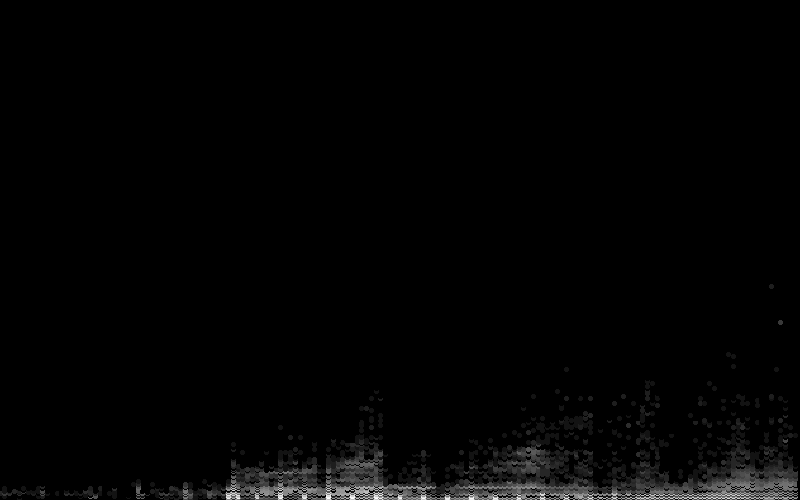

In [7]:
cvs = ds.Canvas(800, 500, x_range = (ny['yearbuilt'].min(), ny['yearbuilt'].max()), 
                                y_range = (ny['numfloors'].min(), ny['numfloors'].max()))
agg = cvs.points(ny, 'yearbuilt', 'numfloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.

Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

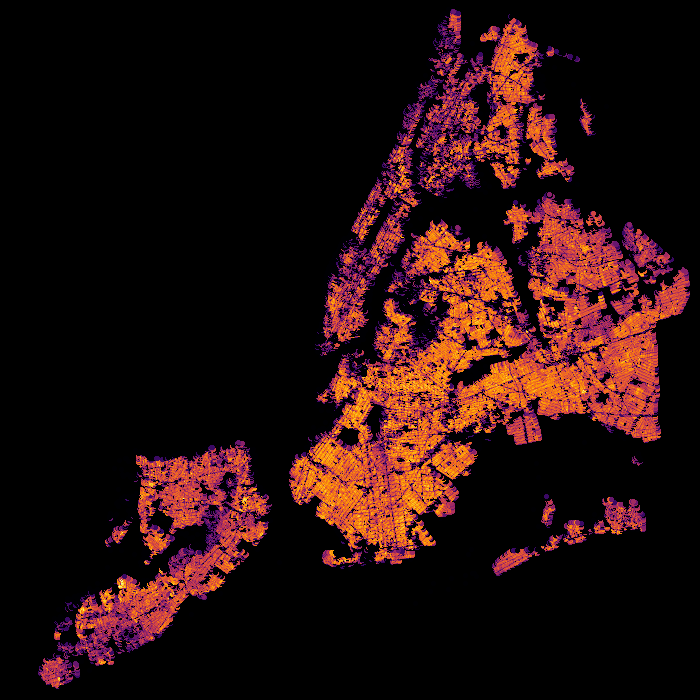

In [8]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their [github repo](https://github.com/bokeh/datashader/tree/master/examples). I would focus on the [visualization pipeline](https://anaconda.org/jbednar/pipeline/notebook) and the [US Census](https://anaconda.org/jbednar/census/notebook) Example for the question below. Feel free to use my samples as templates as well when you work on this problem.

### Question

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the [Pluto data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=17v1_1), you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about [bivariate choropleth maps](http://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/), and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

### Answer

This analysis will rely on assessed values per square feet.  This puts the units on a comparable basis.

The first step will be to aggrgate the the assessed values and areas.  The lot area is in square feet.  The building area is generally in gross square feet with the exception of condos.  Their areas are in net square feet (net of what is not in the data dictionary).  

There are some cases where the land or building areas are zero.  These cases will be removed from the analysis.  The data is seperated into three classes with at the 33rd and 66th percentile.

In [9]:
# Aggregate the assessed value and square footage by building
av = ny.groupby(['bbl'])[['assessland', 'assesstot', 'bldgarea', 'lotarea']].agg('sum').reset_index()

# Back out the building assessed value
av['assessbuilding'] = av.assesstot - av.assessland

# Compute assessed values per square foot
av['building_av'] = av.assessbuilding / av.bldgarea
av['land_av'] = av.assessland / av.lotarea

# Correct errors
av.loc[av.building_av == np.Inf, 'building_av'] = np.nan
av.loc[av.land_av == np.Inf, 'land_av'] = np.nan

# Extract the cut of points
land_low = np.nanpercentile(av.land_av, 33)
land_high = np.nanpercentile(av.land_av, 66)
building_low = np.nanpercentile(av.building_av, 33)
building_high = np.nanpercentile(av.building_av, 66)

# Classify the data
def classify_land_av(x):
    if x > land_high:
        return("High Land")
    elif x < land_low:
        return("Low Land")
    else:
        return("Mid Land")
        
def classify_building_av(x):
    if x > building_high:
        return("High Building")
    elif x < building_low:
        return("Low Building")
    else:
        return("Mid Building")
    
av['land_av_class'] = av.land_av.apply(classify_land_av)
av['building_av_class'] = av.building_av.apply(classify_building_av)

# Bring them together in the bivariate class
av['bivariate'] = av.building_av_class + "/" + av.land_av_class

# Change the NAs to Unknown
av.loc[np.isnan(av.building_av), 'bivariate'] = "Unknown"
av.loc[np.isnan(av.land_av), 'bivariate'] = "Unknown"

# Change the type to category
av.bivariate = av.bivariate.astype("category")

# Join this back up with our coordinates
ny = pd.merge(ny, av[['bbl', 'bivariate']], on = 'bbl')

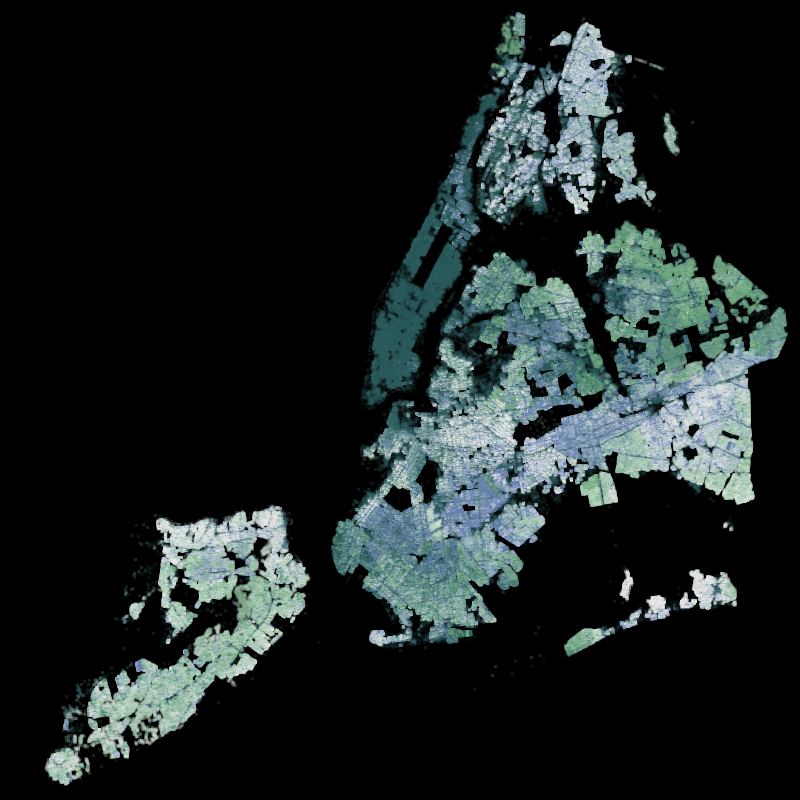

In [10]:
# Let's plot the data!

# Color scheme taken from Joshua Steven's blog post
my_color_scheme = {"High Building/Low Land": "#73ae80",
                   "High Building/Mid Land": "#5a9178",
                   "High Building/High Land": "#2a5a5b",
                   "Mid Building/Low Land": "#b8d6be",
                   "Mid Building/Mid Land": "#90b2b3",
                   "Mid Building/High Land": "#567994",
                   "Low Building/Low Land": "#e8e8e8",
                   "Low Building/Mid Land": "#b5c0da",
                   "Low Building/High Land": "#6c83b5",
                   "Unknown": "#574249"}

# Reuse the example code
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
# Except for some minor changes (Thank you Stack Overflow!)
cvs = ds.Canvas(800, 800, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat', ds.count_cat('bivariate'))
view = tf.shade(agg, color_key = my_color_scheme)
export(tf.spread(view, px=1), 'cloropleth')

<table>
    <tr style="background:#fff;"><th><th>Low Land</th><th>Mid Land</th><th>High Land</th></tr>
    <tr style="background:#fff;"><th>High Building</th><td style="background:#73ae80">&nbsp;</td><td style="background:#5a9178;">&nbsp;</td><td style="background:#2a5a5b;">&nbsp;</td></tr>
    <tr style="background:#fff;"><th>Mid Building</th><td style="background:#b8d6be">&nbsp;</td><td style="background:#90b2b3;">&nbsp;</td><td style="background:#567994;">&nbsp;</td></tr>
    <tr style="background:#fff;"><th>Low Building</th><td style="background:#e8e8e8">&nbsp;</td><td style="background:#b5c0da;">&nbsp;</td><td style="background:#6c83b5;">&nbsp;</td></tr>
    <tr style="background:#fff;"><th style="text-align:left;" colspan="3">Unknown</th><td style="background:#574249;">&nbsp;</td></tr>
</table> 

### Overbuilt

Overbuilt are buildings that assess value is high and the land assessed value is low.  They will be the green dots in the map below.

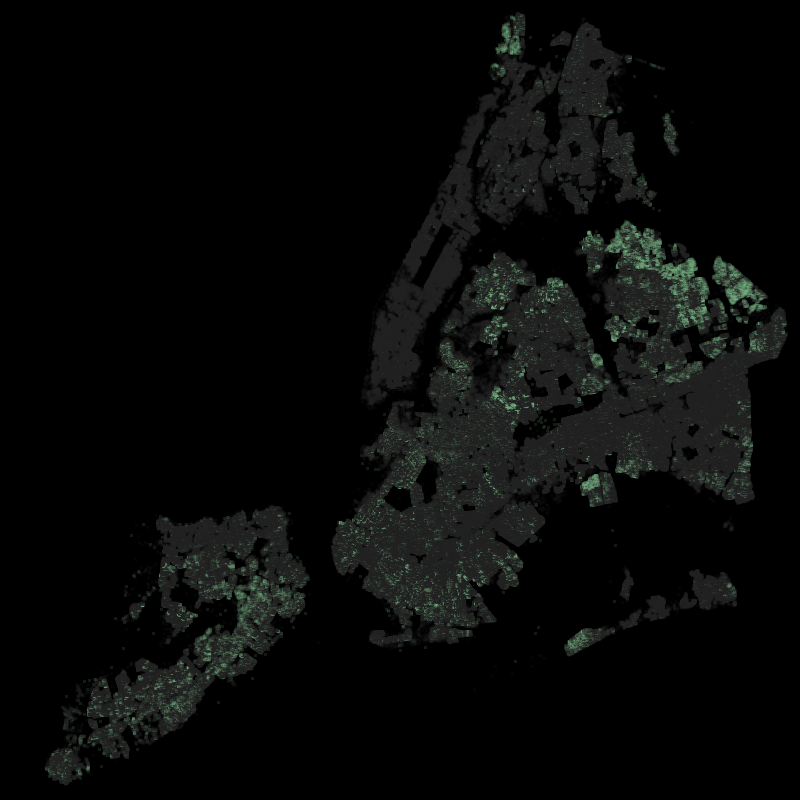

In [11]:
overbuilt = {"High Building/Low Land": "#73ae80",
             "High Building/Mid Land": "#222222",
             "High Building/High Land": "#222222",
             "Mid Building/Low Land": "#222222",
             "Mid Building/Mid Land": "#222222",
             "Mid Building/High Land": "#222222",
             "Low Building/Low Land": "#222222",
             "Low Building/Mid Land": "#222222",
             "Low Building/High Land": "#222222",
             "Unknown": "#000000"}

cvs = ds.Canvas(800, 800, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat', ds.count_cat('bivariate'))
view = tf.shade(agg, color_key = overbuilt)
export(tf.spread(view, px=1), 'overbuilt')

#### Bronx

* Riverdale

#### Brooklyn

* Park Slope (parts)
* Bay Ridge (parts)

#### Queens

* Howard Beach
* Breezy Point
* Astoria
* Ditmars
* Whitestone
* Bay Terrace
* Saddle Rock
* Harbor Hills

#### Staten Island

* Todt Hill
* Dongan Hills

### Underbuilt

This group is buildings with low buildings and high land value.  It is shown in blue below.

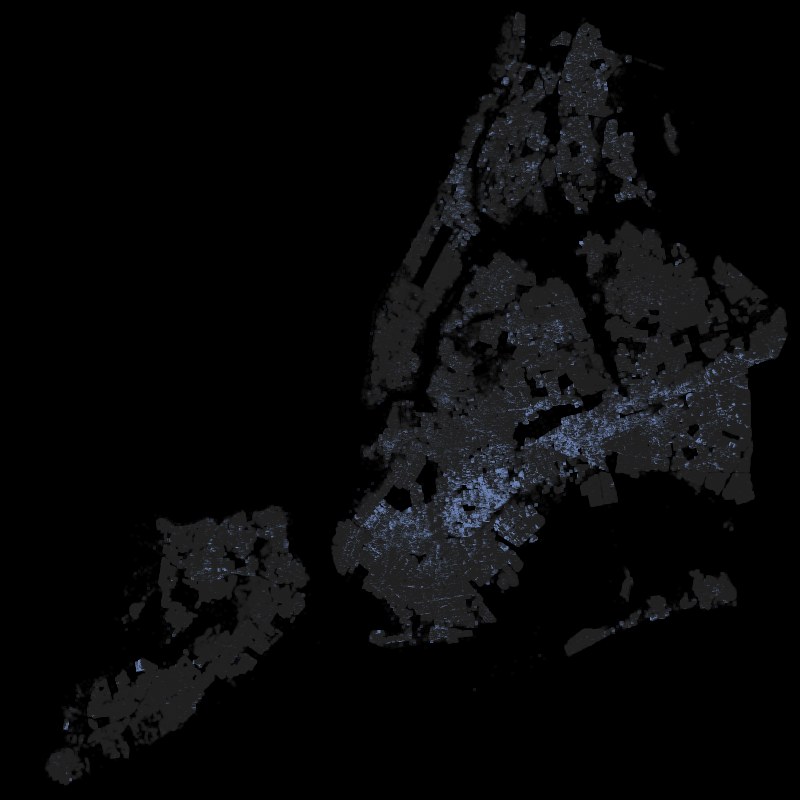

In [12]:
underbuilt = {"High Building/Low Land": "#222222",
                   "High Building/Mid Land": "#222222",
                   "High Building/High Land": "#222222",
                   "Mid Building/Low Land": "#222222",
                   "Mid Building/Mid Land": "#222222",
                   "Mid Building/High Land": "#222222",
                   "Low Building/Low Land": "#222222",
                   "Low Building/Mid Land": "#222222",
                   "Low Building/High Land": "#6c83b5",
                   "Unknown": "#000000"}

cvs = ds.Canvas(800, 800, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat', ds.count_cat('bivariate'))
view = tf.shade(agg, color_key = underbuilt)
export(tf.spread(view, px=1), 'underbuilt')

#### Bronx

* Kingsbridge
* Mott Haven

#### Brooklyn

* Sunset Park
* Flatbush
* East Flatbush
* Brownsville

#### Manhattan

* Harlem

#### Queens

* Woodhaven
* Ozone Park

#### Staten Island

* Arden Hights

### Properly Correlated (Balanced)

These are locations along the diagonal of the bivariate grid.  The building and land assessment are in a similar class.

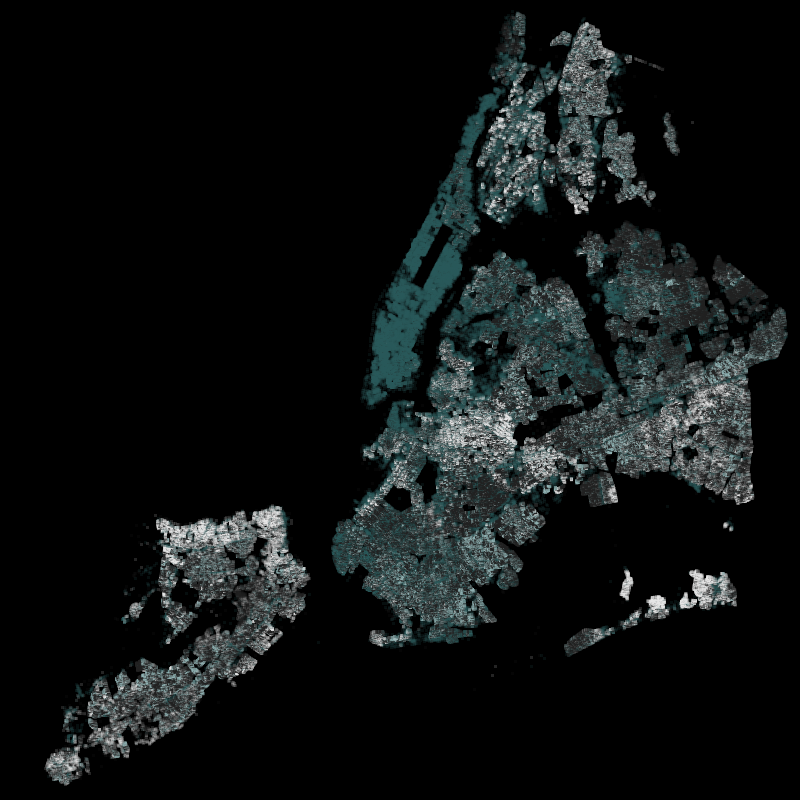

In [13]:
balanced = {"High Building/Low Land": "#222222",
                   "High Building/Mid Land": "#222222",
                   "High Building/High Land": "#2a5a5b",
                   "Mid Building/Low Land": "#222222",
                   "Mid Building/Mid Land": "#90b2b3",
                   "Mid Building/High Land": "#222222",
                   "Low Building/Low Land": "#e8e8e8",
                   "Low Building/Mid Land": "#222222",
                   "Low Building/High Land": "#222222",
                   "Unknown": "#000000"}

cvs = ds.Canvas(800, 800, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat', ds.count_cat('bivariate'))
view = tf.shade(agg, color_key = balanced)
export(tf.spread(view, px=1), 'balanced')

Most of the city falls into this category.  I'm not going to list the neighborhoods.

Source code available at [https://github.com/mikeasilva/CUNY-SPS/blob/master/DATA608/Module2.ipynb](https://github.com/mikeasilva/CUNY-SPS/blob/master/DATA608/Module2.ipynb)